In [1]:
import torch
from torch.utils.data import TensorDataset
import torch.nn.functional as F

def labels_to_mask(labels, year=0):
    # return F.one_hot(labels[:, :, :, year].long()).moveaxis(-1, 1)
    mask = labels[:, :, :, year].to(torch.uint8) - 1
    return mask.long()

def get_data_loaders():
    
    # load tensors
    train_features = torch.load('../data/processed/train_features.pt')
    train_labels = torch.load('../data/processed/train_labels.pt')
    val_features = torch.load('../data/processed/val_features.pt')
    val_labels = torch.load('../data/processed/val_labels.pt')
    test_features = torch.load('../data/processed/test_features.pt')
    test_labels = torch.load('../data/processed/test_labels.pt')

    # transform labels to mask
    train_labels = labels_to_mask(train_labels)
    val_labels = labels_to_mask(val_labels)
    test_labels = labels_to_mask(test_labels)

    # transform features to images by moving channel dimension
    train_features = (train_features.moveaxis(-1, 1).to(torch.uint8) - 1).float()
    val_features = (val_features.moveaxis(-1, 1).to(torch.uint8) - 1).float()
    test_features = (test_features.moveaxis(-1, 1).to(torch.uint8) - 1).float()

    # create datasets
    train_dataset = TensorDataset(train_features, train_labels)
    val_dataset = TensorDataset(val_features, val_labels)
    test_dataset = TensorDataset(test_features, test_labels)

    # create the train, val and test dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=10)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=10)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=10)

    return train_loader, val_loader, test_loader

In [2]:
train_loader, val_loader, test_loader = get_data_loaders()

In [3]:
# Define the model

import pytorch_lightning as pl
import segmentation_models_pytorch as smp

class ForestModel(pl.LightningModule):

    def __init__(self, arch, encoder_name):
        super().__init__()
        self.save_hyperparameters()

        self.model = smp.create_model(
            arch=arch,
            encoder_name=encoder_name,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=10,                 # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=2,                      # model output channels (number of classes in your dataset)
        )

        # preprocessing parameteres for image
        # params = smp.encoders.get_preprocessing_params(encoder_name)
        # self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        # self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True, ignore_index=255)

    def forward(self, image):
        # normalize image here
        # image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        # assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        # assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = torch.argmax(prob_mask, dim=1).long()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask, mask, mode="multiclass", num_classes=2, ignore_index=255)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        loss = torch.tensor([x["loss"] for x in outputs]).mean()

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_loss": loss,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.000001)

/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/

In [7]:
model = ForestModel.load_from_checkpoint(
    "lightning_logs/version_15/checkpoints/epoch=29-step=540.ckpt", 
    arch="FPN", 
    encoder_name="resnet34")
trainer = pl.Trainer(
    accelerator='mps', 
    devices=1,
    max_epochs=30,
    log_every_n_steps=5
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
# model = ForestModel("UNetPlusPlus", "timm-regnety_320")
model = ForestModel("UNet", "resnet34")

In [16]:
trainer = pl.Trainer(
    accelerator='mps', 
    devices=1,
    max_epochs=30,
    log_every_n_steps=5
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.5 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.834    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
from pprint import pprint
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
pprint(valid_metrics)

Validation: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/segmentation_models_pytorch/metrics/functional.py:190: UserWarning: The operator 'aten::histc' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740407425/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  tp = torch.histc(matched.float(), bins=num_classes, min=0, max=num_classes - 1)


[{'valid_dataset_iou': 0.6298602819442749,
  'valid_loss': 0.1382714807987213,
  'valid_per_image_iou': 0.9890040159225464}]


In [9]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
pprint(test_metrics)

Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.6358475685119629,
  'test_loss': 0.05359616503119469,
  'test_per_image_iou': 0.9890989065170288}]


In [10]:
import matplotlib.pyplot as plt

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = logits.sigmoid()

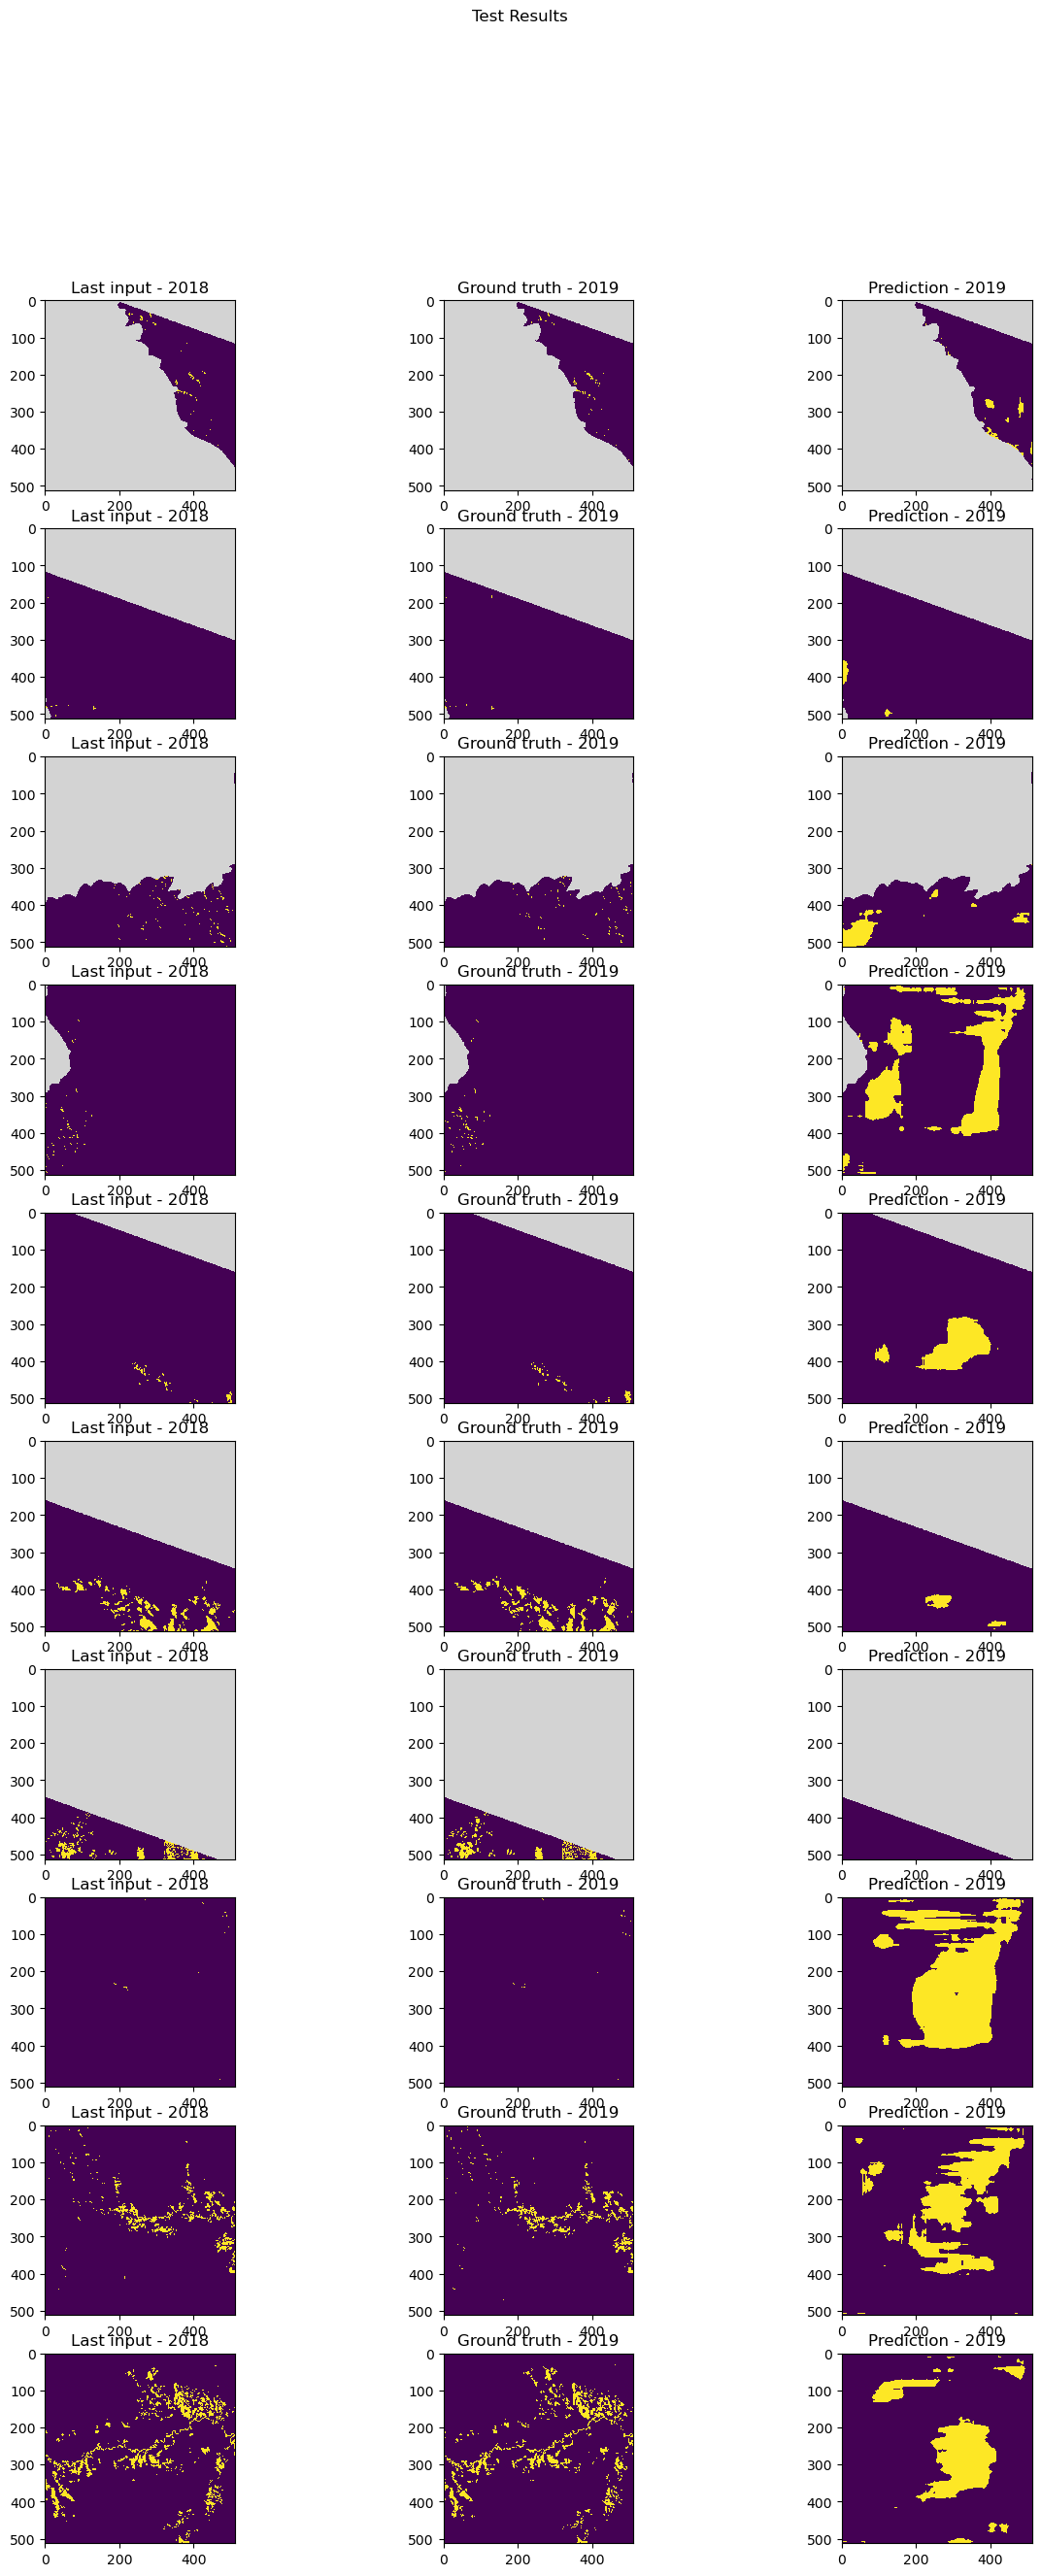

In [14]:
import matplotlib as mpl

i = 0
i_max = 10

cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap.set_over('lightgrey')

fig, axs = plt.subplots(i_max, 3, figsize=(15,10 * int(i_max/3)))
fig.suptitle("Test Results")

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    if i < i_max:
        image = image[-1,:,:]
        axs[i,0].pcolormesh(image, norm=norm, cmap=cmap)
        axs[i,0].set_title("Last input - 2018")
        axs[i,0].invert_yaxis()
        axs[i,0].set_aspect('equal', adjustable='box')

        axs[i,1].pcolormesh(gt_mask, norm=norm, cmap=cmap)
        axs[i,1].set_title("Ground truth - 2019")
        axs[i,1].invert_yaxis()
        axs[i,1].set_aspect('equal', adjustable='box')

        # prediction = F.softmax(pr_mask, dim=0)[1,:,:]
        prediction = torch.argmax(pr_mask, dim=0)
        prediction[image == 255] = 255
        axs[i,2].pcolormesh(prediction, norm=norm, cmap=cmap)
        axs[i,2].set_title("Prediction - 2019")
        axs[i,2].invert_yaxis()
        axs[i,2].set_aspect('equal', adjustable='box')
    i += 1
plt.show()